In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from pandas import concat
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import scipy.io as sio

In [2]:
startTime = datetime.now()

#### Valor del pip y comision a definir:

In [3]:
lots = 0.01
pip = 10000
pip_value = 1.1 *lots
round_cost = 5 *lots

In [4]:
df = pd.read_pickle('EURNOK.pkl')
df = df[['Close']]
df = df.dropna()

In [5]:
df.head(5)

,Close
DateTime,
2015-06-01 00:00:00,8.52613
2015-06-01 00:30:00,8.53023
2015-06-01 01:00:00,8.52764
2015-06-01 01:30:00,8.52674
2015-06-01 02:00:00,8.52684


#### Calculamos el ZScore

In [6]:
mean = df.Close.rolling(40).mean()
std = df.Close.rolling(40).std()
df['zscore'] = (df.Close-mean)/std 

#### Backtest vectorizado

In [7]:
thresholds = []
pips = []
trades = []

for i in np.arange(1.2, 3, 0.1):

    #Cuando ZScore cruce 0 devuelve 0
    df['Zero_X'] = np.where((df.zscore.shift() < 0) & (df.zscore > 0),
                        0, np.where((df.zscore.shift() > 0) &
                                    (df.zscore < 0), 0, 2))

    #Si Zscore cruza threshold, devuelve señal compra o venta
    df['position'] = np.where(df.zscore.shift() > i, -1,
                          np.where(df.zscore.shift() < -i, 1,
                                   np.where(df.Zero_X.shift() == 0,
                                            0, np.nan)))
    df.ffill(inplace=True)

    df['trades'] = np.where((df.position.shift() == 0) &
                            (df.position != 0), 1, 0)

    df['sym_1_Return'] = np.log(df.iloc[:,0] / df.iloc[:,0].shift())
    Total_trades = df.trades.sum()
    df['sym_1_profit'] = (df.sym_1_Return * df.position)
    df['cumulative_pips'] = (np.cumsum(df.sym_1_profit)*pip)

    Total_pips_1 = df.cumulative_pips.iloc[-1]
    pips_trade_1 = Total_pips_1/Total_trades
    
    thresholds.append(i)
    pips.append(pips_trade_1)
    trades.append(Total_trades)

In [8]:
import matplotlib.pyplot as plt

#### Pips trade vs threshold

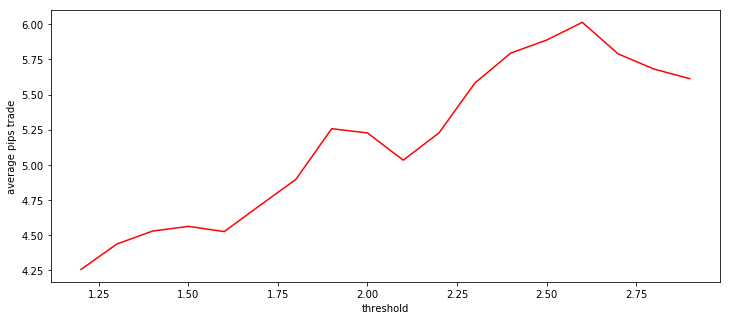

In [9]:
plt.figure(figsize=(12,5))
plt.xlabel('threshold')
plt.ylabel('average pips trade')
plt.plot(thresholds, pips, color='r', label='pips trade')
plt.show()

#### Num trades vs threshold

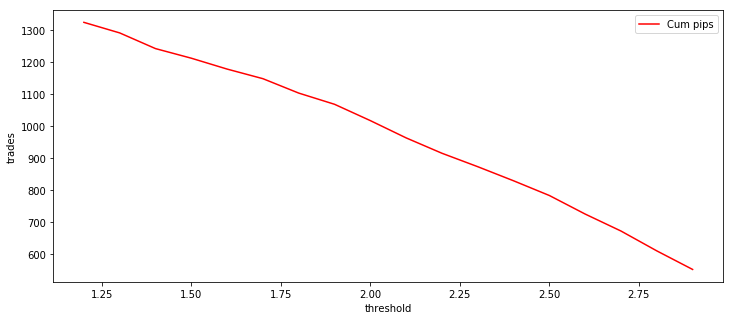

In [10]:
plt.figure(figsize=(12,5))
plt.xlabel('threshold')
plt.ylabel('trades')
plt.plot(thresholds, trades, color='r',  label='Cum pips')
plt.legend()
plt.show()

In [11]:
df['cumulative_dolars'] = (np.cumsum(df.sym_1_profit)*pip)*pip_value

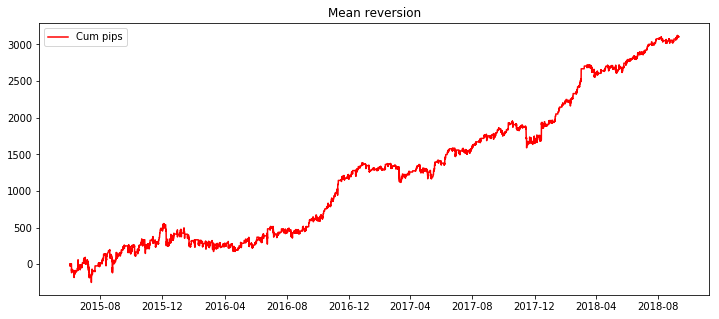

In [12]:
plt.figure(figsize=(12,5))
index = df.index.to_pydatetime()
plt.title('Mean reversion')
plt.plot(index, df['cumulative_pips'].values, color='r', label='Cum pips')
plt.legend()
plt.show()

In [13]:
print('Total trades is: ', Total_trades)

Total trades is:  553


In [14]:
print('Average pips trade: ', float("{0:.2f}".format(pips_trade_1)))

Average pips trade:  5.61


In [15]:
print(datetime.now() - startTime)

0:00:00.829000
